**Evidence 2 - Time Series Model Report**

### **Team:**

- **Alma Ivone Santiago Hernández - A00836636.**
- **Víctor Benito García Rocha - A01232580.**
- **Bruno Chavez Meza- A01737301.**

### **Context:**

The Ministry of Economy aims to estimate Mexican manufacturing exports based on the peso-dollar exchange rate.
- For this, it requires using a precise model that passes:
    - The tests of normality in the residuals.
    - Non stationarity.
    - Serial autocorrelation.

### **Please determine:**

- The existence of a cointegration relationship.
    - If it exists, apply a VECM model.
    - If it does not exist, apply a VAR model.

### **Libraries**

In [1]:
# !pip install statsmodels
# !pip install --upgrade statsmodels
# import locale
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import seaborn as sns #plots
import numpy as np
import statistics as stats # statistics
import matplotlib.pyplot as plt #graphs
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro, boxcox
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#upload since our PC-desktop
# from google.colab import files
# files.upload()

### **Data exploratory analysis**

- **Import the data**

In [3]:
df = pd.read_csv("Evidence2.csv", encoding="latin-1", delimiter=";")
df.head(10)

,date,exp_td,exchange
0,1/1/00 00:00,9566330,9.4878
1,1/2/00 00:00,11358821,9.4252
2,1/3/00 00:00,11581780,9.2876
3,1/4/00 00:00,10632048,9.3903
4,1/5/00 00:00,12800667,9.5158
5,1/6/00 00:00,12179406,9.8295
6,1/7/00 00:00,11886127,9.4212
7,1/8/00 00:00,13430103,9.2709
8,1/9/00 00:00,12300029,9.3540
9,1/10/00 00:00,14172254,9.5314


- **Data types**

In [4]:
df.dtypes

date         object
exp_td        int64
exchange    float64
dtype: object

In [5]:
#security copy
df0=df.copy()

- **Convert the date column to datetime**

In [6]:
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%y %H:%M")
df.dtypes

date        datetime64[ns]
exp_td               int64
exchange           float64
dtype: object

- **Set the date as the index**

In [7]:
df.set_index("date", inplace=True)
df.head() # From 2000-01-01

,exp_td,exchange
date,,
2000-01-01,9566330,9.4878
2000-02-01,11358821,9.4252
2000-03-01,11581780,9.2876
2000-04-01,10632048,9.3903
2000-05-01,12800667,9.5158


In [8]:
df.tail() # To 2024-04-01

,exp_td,exchange
date,,
2023-12-01,43993414,17.1860
2024-01-01,36571021,17.0873
2024-02-01,45047576,17.0898
2024-03-01,45458225,16.7918
2024-04-01,45972275,16.8104


- **Examine data and clean data frame**

In [9]:
df.info()
#exchange= Monetary aggregate (peso-dollar exchange rate.)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2000-01-01 to 2024-04-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   exp_td    292 non-null    int64  
 1   exchange  292 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.8 KB


- **See if there are missing values**

In [10]:
df.isnull().sum()

exp_td      0
exchange    0
dtype: int64

- **See if there are duplicated values**

In [11]:
duplicated_rows = df.duplicated()
print("Filas duplicadas:")
print(df[duplicated_rows])

Filas duplicadas:
Empty DataFrame
Columns: [exp_td, exchange]
Index: []


In [12]:
num_duplicated = duplicated_rows.sum()
print(f"Número de filas duplicadas: {num_duplicated}")

Número de filas duplicadas: 0


- **Descriptive statistics**

In [13]:
df_descriptive_stats = df.describe()
df_descriptive_stats.round(1)

,exp_td,exchange
count,292.0,292.0
mean,24281551.2,14.4
std,10138428.4,4.0
min,9566330.0,9.1
25%,15022526.2,10.9
50%,23615830.5,13.0
75%,31733338.5,18.6
max,47629593.0,24.3


### **General data visualization**

Plot Time Series

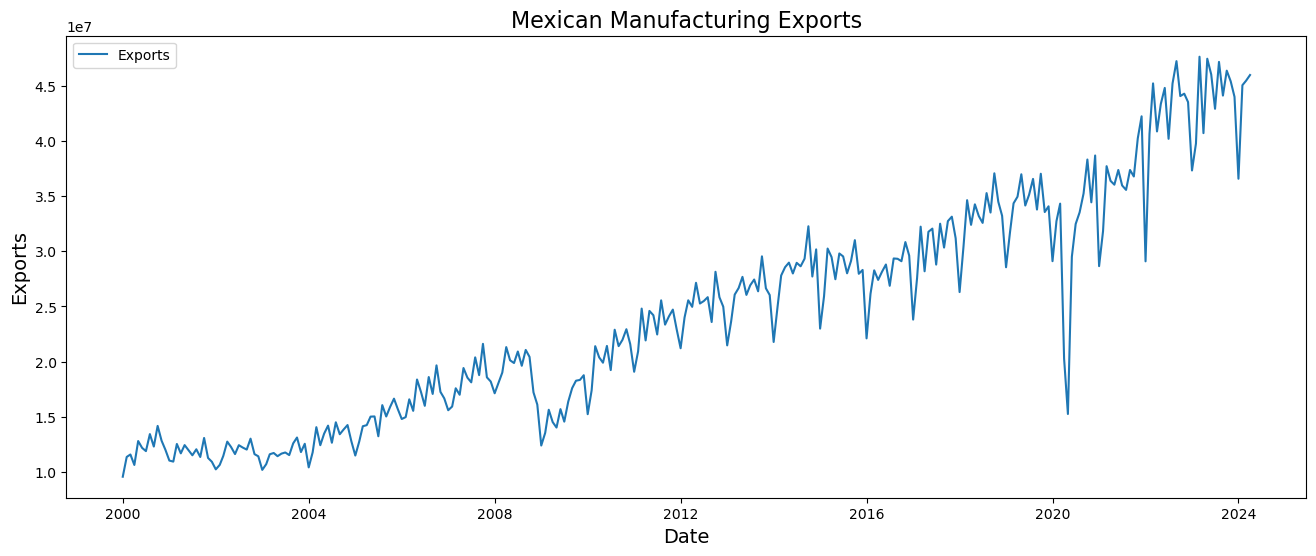

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(df["exp_td"], label="Exports")
plt.title("Mexican Manufacturing Exports", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Exports", fontsize=14)
plt.legend()
plt.show()

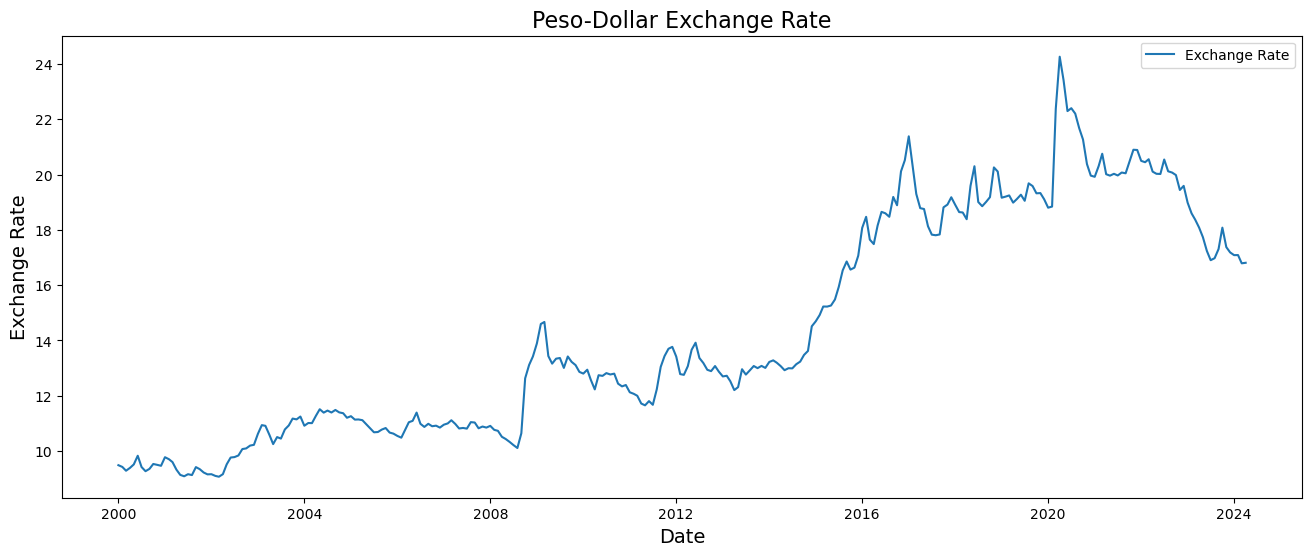

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df["exchange"], label="Exchange Rate")
plt.title("Peso-Dollar Exchange Rate", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Exchange Rate", fontsize=14)
plt.legend()
plt.show()

**Outliers:**

In the exports data, there's a significant drop around 2020, likely due to the COVID-19 pandemic. This is an important event to note but not necessarily an outlier to remove.
The exchange rate shows a sharp spike around 2020 as well. Again, this is likely related to the pandemic and should be noted but not necessarily removed.

**Trends:**

Exports show a clear upward trend over time, with seasonal patterns.
The exchange rate also shows an overall upward trend, but with more abrupt changes and less clear seasonality.

For this, it requires using a precise model that passes the tests of normality in the residuals, non stationarity, and serial autocorrelation.

### **Normality test**

We started by cleaning up the 'inflation' and 'M1' data, replacing those zero values with NaNs since they were probably just missing data. Then we built a simple regression model to see the relationship between 'inflation' and 'M1'. The next step was to check if the residuals from that model looked normally distributed, which is a key assumption for a lot of the statistical analysis we might do down the line.

- **Check for normality visually and statistically**

In [16]:
df['exp_td'] = df['exp_td'].replace(0, np.nan)
df['exchange'] = df['exchange'].replace(0, np.nan)

- **Regression model in levels**

In [17]:
X = sm.add_constant(df['exchange'])  # Adding a constant for the intercept
model_0 = sm.OLS(df['exp_td'], X).fit()  # OLS regression
residuals_0 = model_0.resid  # Extracting residuals

- **Shapiro-Wilk test on the residuals**

The p-value is less than 0.05, so we reject the null hypothesis that the residuals are normally distributed (so they are not, which is not ideal).

In [18]:
shapiro_results_0 = stats.shapiro(residuals_0)
print(f"Shapiro-Wilk test statistic: {shapiro_results_0.statistic}, p-value: {shapiro_results_0.pvalue}")

Shapiro-Wilk test statistic: 0.9451665161144673, p-value: 5.7738667254954525e-09


- **Plot Q-Q plots**

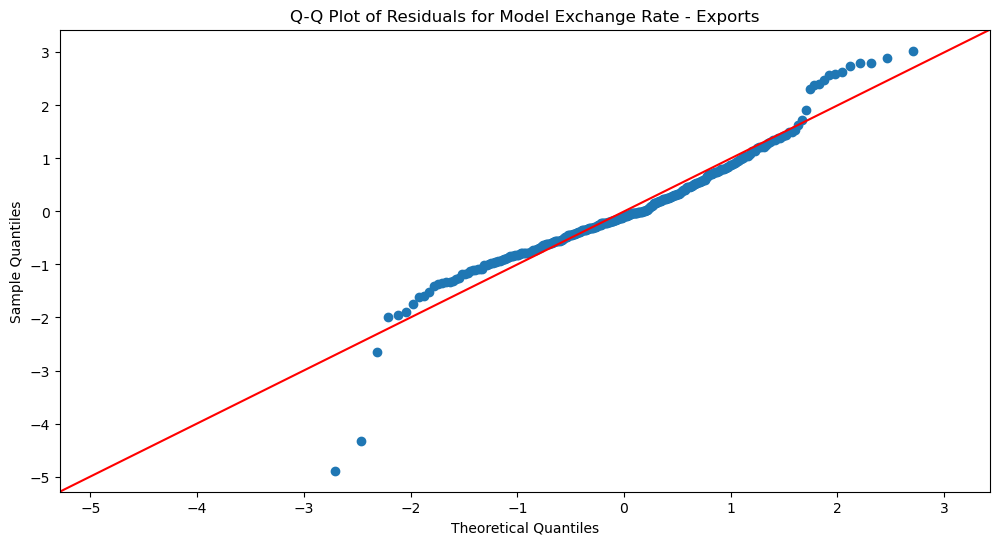

In [19]:
fig, ax = plt.subplots(figsize=(12, 6)) # Create a figure and a single axes
sm.qqplot(residuals_0, line='45', fit=True, ax=ax) # Create the Q-Q plot on the single axes
ax.set_title('Q-Q Plot of Residuals for Model Exchange Rate - Exports') # Set the title for the plot
plt.show() # Display the plot

*In* this case, the p-value should be greater than 0.05 to be considered with normal residuals. Hence, the residuals do not follow a normal path.
0.00000000577493 < 0.05. It is not normally distributed.




**What to do: 1) Apply a logarithmic Transformation, 2) Apply Squared root, 3)BOX_COX transformation, 4) Difference the time series and remove seasonal effects in order to apply robust models such as VAR or VECM**   

- **Apply a logarithmic Transformation.**

It is a common approach to stabilize normality, variance and potentially linearize relationships, making the data more suitable for linear modeling.

In [20]:
df['log_exp_td'] = np.log(df['exp_td'])
df['log_exchange'] = np.log(df['exchange'])
df.head()

,exp_td,exchange,log_exp_td,log_exchange
date,,,,
2000-01-01,9566330,9.4878,16.073760,2.250007
2000-02-01,11358821,9.4252,16.245505,2.243387
2000-03-01,11581780,9.2876,16.264944,2.228680
2000-04-01,10632048,9.3903,16.179383,2.239677
2000-05-01,12800667,9.5158,16.365008,2.252954


- **Regression model of log-transformed data**

In [21]:
X1 = sm.add_constant(df['log_exchange'])  # adding a constant for the intercept
model_log = sm.OLS(df['log_exp_td'], X1).fit()  # OLS regression
residuals_log = model_log.resid  # extracting residuals

- **Shapiro-Wilk test on the residuals**

We still reject the null hypothesis that the residuals are normally distributed.

In [22]:
shapiro_results_log = stats.shapiro(residuals_log)
print(f"Shapiro-Wilk test statistic: {shapiro_results_log.statistic}, p-value: {shapiro_results_log.pvalue}")


Shapiro-Wilk test statistic: 0.9762957571712423, p-value: 9.192137693006651e-05


- **Plot Q-Q plots**

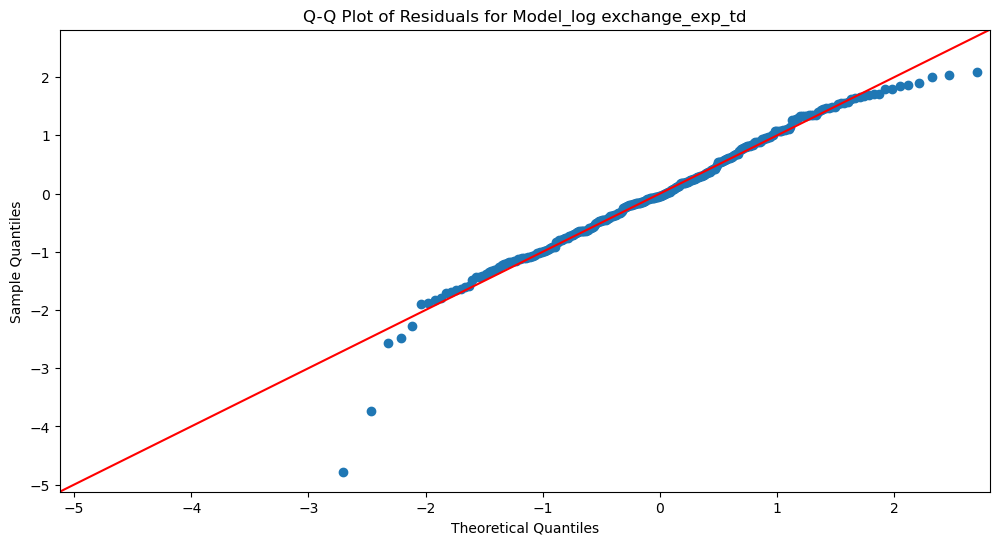

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure and a single axes

sm.qqplot(residuals_log, line='45', fit=True, ax=ax)  # Create the Q-Q plot on the single axes
ax.set_title('Q-Q Plot of Residuals for Model_log exchange_exp_td')  # Set the title for the plot

plt.show()  # Display the plot

With Log transformation, The residuals of the model still don't follow



"Normality" P-value=0.00009191731078317389<0.05

While non-normal residuals are a significant concern in linear regression, they do not necessarily invalidate your model.

- **Apply Squared root transformation**

In [24]:
df['sqrt_exchange'] = np.sqrt(df['exchange'])
df['sqrt_exp_td'] = np.sqrt(df['exp_td'])
df.head()


,exp_td,exchange,log_exp_td,log_exchange,sqrt_exchange,sqrt_exp_td
date,,,,,,
2000-01-01,9566330,9.4878,16.073760,2.250007,3.080227,3092.948432
2000-02-01,11358821,9.4252,16.245505,2.243387,3.070049,3370.285003
2000-03-01,11581780,9.2876,16.264944,2.228680,3.047556,3403.201434
2000-04-01,10632048,9.3903,16.179383,2.239677,3.064360,3260.682137
2000-05-01,12800667,9.5158,16.365008,2.252954,3.084769,3577.801979


- **Regression model of squared root-transformed data**

In [25]:
# Adding a constant to the independent variable
df['const'] = 1

# Fit the time series model (e.g., Ordinary Least Squares regression)
model = sm.OLS(df['sqrt_exp_td'], df[['const', 'sqrt_exchange']])
results = model.fit()

# Print the summary of the regression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            sqrt_exp_td   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     704.7
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           1.33e-79
Time:                        21:00:22   Log-Likelihood:                -2259.4
No. Observations:                 292   AIC:                             4523.
Df Residuals:                     290   BIC:                             4530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1473.2585    239.262     -6.158

In [26]:
# Get the residuals
residuals_sqrt = results.resid

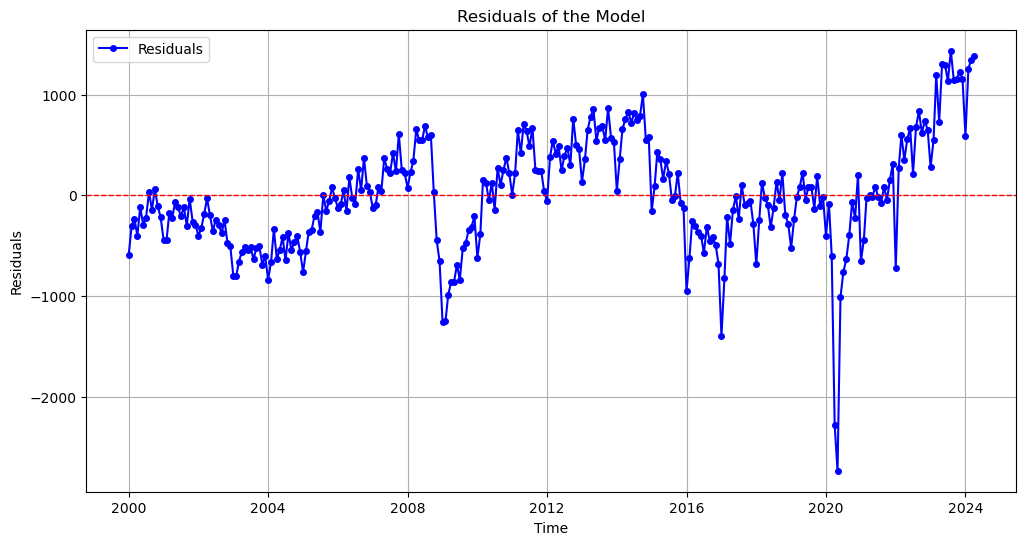

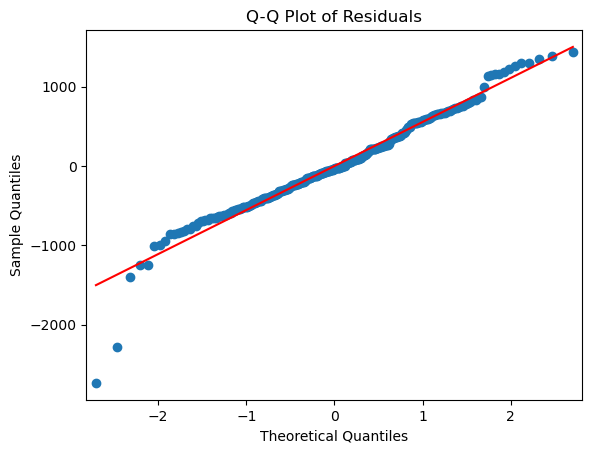

In [27]:
# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_sqrt, label='Residuals', color='blue', linestyle='-', marker='o', markersize=4)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals of the Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

# Check for normality of residuals
# Plotting a Q-Q plot
sm.qqplot(residuals_sqrt, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

- **Shapiro-Wilk test on the residuals**

We still reject the null hypothesis that the residuals are normally distributed.

In [28]:
shapiro_results_sqrt = stats.shapiro(residuals_sqrt)
print(f"Shapiro-Wilk test statistic: {shapiro_results_sqrt.statistic}, p-value: {shapiro_results_sqrt.pvalue}")

Shapiro-Wilk test statistic: 0.9696943295391104, p-value: 7.937305892493719e-06


- **Jarque-Bera test**

We reject the null hypothesis that the residuals are normally distributed.

In [29]:
# Performing Jarque-Bera test for normality
jarque_bera_test = stats.jarque_bera(residuals_sqrt)
print('Jarque-Bera Test p-value:', jarque_bera_test[1])

# Summary of normality tests
if shapiro_results_sqrt.pvalue > 0.05 and jarque_bera_test[1] > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

Jarque-Bera Test p-value: 2.6550341335734497e-15
Residuals do not appear to be normally distributed.


- **BOX_COX transformation**

In [30]:
df['exp_td_boxcox'], lambda_exp = boxcox(df['exp_td'])
df['exchange_boxcox'], lambda_ex = boxcox(df['exchange'])
df.head()

,exp_td,exchange,log_exp_td,log_exchange,sqrt_exchange,sqrt_exp_td,const,exp_td_boxcox,exchange_boxcox
date,,,,,,,,,
2000-01-01,9566330,9.4878,16.073760,2.250007,3.080227,3092.948432,1,83.099198,1.265962
2000-02-01,11358821,9.4252,16.245505,2.243387,3.070049,3370.285003,1,85.713075,1.264130
2000-03-01,11581780,9.2876,16.264944,2.228680,3.047556,3403.201434,1,86.013713,1.260033
2000-04-01,10632048,9.3903,16.179383,2.239677,3.064360,3260.682137,1,84.697769,1.263100
2000-05-01,12800667,9.5158,16.365008,2.252954,3.084769,3577.801979,1,87.576989,1.266776


- **Regression model of Box-Cox transformed data**

In [31]:
X = sm.add_constant(df['exchange_boxcox'])  # Adding a constant for the intercept
model_boxcox = sm.OLS(df['exp_td_boxcox'], X).fit()  # OLS regression
residuals_boxcox = model_boxcox.resid  # Extracting residuals

- **Shapiro-Wilk test on the residuals**

We still reject the null hypothesis that the residuals are normally distributed, but the p-value is higher than before!

In [32]:
shapiro_results_boxcox = stats.shapiro(residuals_boxcox)
print(f"Shapiro-Wilk test statistic: {shapiro_results_boxcox.statistic}, p-value: {shapiro_results_boxcox.pvalue}")

Shapiro-Wilk test statistic: 0.9790673081421386, p-value: 0.00028159457773243196


- **Jarque-Bera test**

We reject the null hypothesis that the residuals are normally distributed.

In [33]:
jb_results_boxcox = stats.jarque_bera(residuals_boxcox)
print(f"Jarque-Bera test statistic: {jb_results_boxcox.statistic}, p-value: {jb_results_boxcox.pvalue}")

Jarque-Bera test statistic: 39.41502993278129, p-value: 2.761436100172404e-09


We could also solve stationarity using differences and a VAR model, so let's try that.

### **Stationarity and Autocorrelation**

Apply Augmented Dickey Fuller Test
In the ADF test:
Ho: Time Series is considered non-stationary
Ha: Time series is stationary when p-value of the test <0.05

- **Let's create a function to apply the ADF test**

In [34]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles differenced data
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # .to_string() removes the line "dtype: float64"

- **Perform the ADF test on each column.**

We fail to reject the null hypothesis that the time series is non-stationary, as the p-value is greater than 0.05 (so the time series is non-stationary, which is not ideal).

In [35]:
adf_test(df['exp_td'], title='Exports')

Augmented Dickey-Fuller Test: Exports
ADF test statistic        0.794083
p-value                   0.991540
# lags used              15.000000
# observations          276.000000
critical value (1%)      -3.454267
critical value (5%)      -2.872070
critical value (10%)     -2.572381


In [36]:
adf_test(df['exchange'], title='Exchange Rate')

Augmented Dickey-Fuller Test: Exchange Rate
ADF test statistic       -1.302771
p-value                   0.627904
# lags used               2.000000
# observations          289.000000
critical value (1%)      -3.453182
critical value (5%)      -2.871593
critical value (10%)     -2.572127


We can see that both variables (Exports and Exchange Rate), have a unit root and are "non stationary", since all p-values are  greater than 0.05 regrettably.

P_values:
- Exports: 0.99
- Exchange Rate: 0.63



### **Check for autocorrelation**

Plot Autocorrelation Function (ACF). You can do it over the variables in levels or, you can check it over the residuals of a model.

Peaks outside the confidence bands indicate significant autocorrelation. That is, the values ​​of the series are influenced by its previous values ​​in those lags.

- **Plotting the ACF for the exports**

<Figure size 1200x600 with 0 Axes>

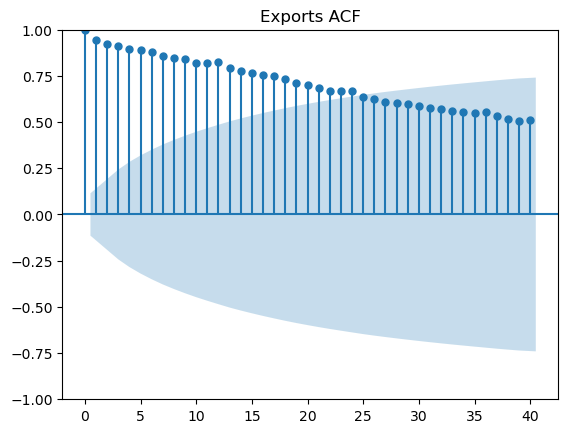

In [37]:
plt.figure(figsize=(12, 6))
plot_acf(df['exp_td'], lags=40, title='Exports ACF')
plt.show()

- **Plotting the ACF for the exchange rate**

Both series show strong autocorrelation that decays slowly, indicating non-stationarity in both series.

<Figure size 1200x600 with 0 Axes>

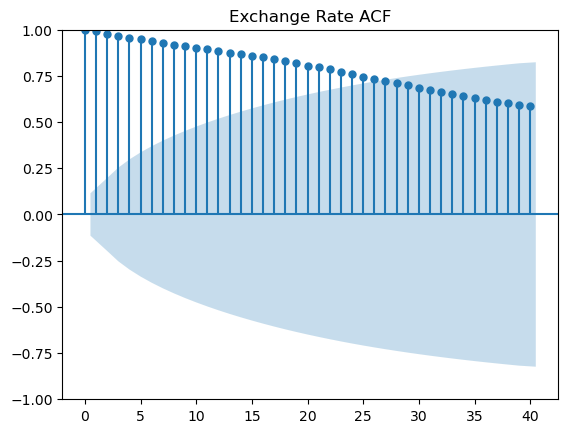

In [38]:
plt.figure(figsize=(12, 6))
plot_acf(df['exchange'], lags=40, title='Exchange Rate ACF')
plt.show()

**To see autocorrelation in the residuals of a model, let's apply a GLS time series model with differences in the variables (transform variables).**

#### **Check for required differences to apply an GLS model in time series**

- **Function to find the number of differences necessary to make the series stationary (maximum 5)**

In [39]:
def find_differencing(series, max_diff=5):
    diff = 0
    current_series = series.copy()

    while not adf_test(current_series) and diff < max_diff:
        if len(current_series) <= 1:
            print("The series is too short for further differencing.")
            return diff
        diff += 1
        current_series = current_series.diff().dropna()
        print(f"Differencing {diff} for the current column: ADF p-value = {adfuller(current_series)[1]}")

    return diff

In [40]:
df.head

<bound method NDFrame.head of               exp_td  exchange  log_exp_td  log_exchange  sqrt_exchange  \
date                                                                      
2000-01-01   9566330    9.4878   16.073760      2.250007       3.080227   
2000-02-01  11358821    9.4252   16.245505      2.243387       3.070049   
2000-03-01  11581780    9.2876   16.264944      2.228680       3.047556   
2000-04-01  10632048    9.3903   16.179383      2.239677       3.064360   
2000-05-01  12800667    9.5158   16.365008      2.252954       3.084769   
...              ...       ...         ...           ...            ...   
2023-12-01  43993414   17.1860   17.599550      2.844095       4.145600   
2024-01-01  36571021   17.0873   17.414767      2.838335       4.133679   
2024-02-01  45047576   17.0898   17.623230      2.838482       4.133981   
2024-03-01  45458225   16.7918   17.632304      2.820891       4.097780   
2024-04-01  45972275   16.8104   17.643549      2.821998       4.10004

In [41]:
#Let's make a copy to drop variables that we are not going to use, keep "logs"
df2=df.copy()
df2.drop(['log_exp_td', 'log_exchange', 'sqrt_exchange', 'sqrt_exp_td', 'const', 'exp_td_boxcox' , 'exchange_boxcox'], axis=1, inplace=True)

In [42]:
df2

,exp_td,exchange
date,,
2000-01-01,9566330,9.4878
2000-02-01,11358821,9.4252
2000-03-01,11581780,9.2876
2000-04-01,10632048,9.3903
2000-05-01,12800667,9.5158
...,...,...
2023-12-01,43993414,17.1860
2024-01-01,36571021,17.0873
2024-02-01,45047576,17.0898


- **Calculate the number of differences required for each column**

Since we need p-value < 0.05, both series only need 1 difference to be stationary.

In [43]:
# Calculate the number of differences needed for each column (maximum 5)
# exp_td need 1 difference:  p-value = 3.859383374989132e-06 = 0.000003859383374989132 < 0.05
# exchange need 1 difference: 3.1163886997637402e-24 = 0.0000000000000000000000031163886997637402 < 0.05
resultados_diferenciacion = {}
for columna in df2.columns:
    print(f"\nAnalizando la columna {columna}...")
    num_diff = find_differencing(df2[columna], max_diff=5)
    resultados_diferenciacion[columna] = num_diff


Analizando la columna exp_td...
Augmented Dickey-Fuller Test: 
ADF test statistic        0.794083
p-value                   0.991540
# lags used              15.000000
# observations          276.000000
critical value (1%)      -3.454267
critical value (5%)      -2.872070
critical value (10%)     -2.572381
Differencing 1 for the current column: ADF p-value = 3.859383374989325e-06
Augmented Dickey-Fuller Test: 


ADF test statistic       -5.372966
p-value                   0.000004
# lags used              14.000000
# observations          276.000000
critical value (1%)      -3.454267
critical value (5%)      -2.872070
critical value (10%)     -2.572381
Differencing 2 for the current column: ADF p-value = 1.0234407766638382e-15
Augmented Dickey-Fuller Test: 
ADF test statistic     -9.315226e+00
p-value                 1.023441e-15
# lags used             1.500000e+01
# observations          2.740000e+02
critical value (1%)    -3.454444e+00
critical value (5%)    -2.872147e+00
critical value (10%)   -2.572422e+00
Differencing 3 for the current column: ADF p-value = 4.750827649961375e-21
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.149044e+01
p-value                 4.750828e-21
# lags used             1.600000e+01
# observations          2.720000e+02
critical value (1%)    -3.454622e+00
critical value (5%)    -2.872225e+00
critical value (10%)   -2.572464e+00
Differencing 4 for the c

exp_td need 1 difference:

exchange need 1 difference:

#### **Apply differentiation and prepare data for GLS modeling**

Differencing is a common technique used to remove trends and make the data stationary.

- **Columns that need differentiation and the number of differences required**

In [44]:
columns_to_diff = {'exp_td': 1, 'exchange': 1}

- **Columns that do not need differentiation**

In [45]:
columns_no_diff = []

- **Apply differentiation to selected columns**

In [46]:
df_diff = df2.copy()
for col, n_diffs in columns_to_diff.items():
    for _ in range(n_diffs):
        df_diff[col] = df_diff[col].diff()
df_diff = df_diff.dropna()

- **Ensure all columns are aligned (here we just use an empty list as no columns are undifferentiated)**

In [47]:
if columns_no_diff:
    df_non_diff = df[columns_no_diff].iloc[max(columns_to_diff.values()):]
    # Combine differentiated and non-differentiated columns
    df_combined = pd.concat([df_diff[columns_to_diff.keys()], df_non_diff], axis=1).dropna()
else:
    df_combined = df_diff[columns_to_diff.keys()]

In [48]:
print("Combined Data (Differenced where needed):")
print(df_combined.head())

Combined Data (Differenced where needed):
               exp_td  exchange
date                           
2000-02-01  1792491.0   -0.0626
2000-03-01   222959.0   -0.1376
2000-04-01  -949732.0    0.1027
2000-05-01  2168619.0    0.1255
2000-06-01  -621261.0    0.3137


#### **Train-Test Split**
- **Split the differenced data into training and testing sets, using the last 12 observations for testing.**

In [49]:
test_obs = 12

train = df_combined[:-test_obs]
test = df_combined[-test_obs:]

In [50]:
print("Train set:")
print(train.tail())

Train set:
               exp_td  exchange
date                           
2022-12-01  -759524.0    0.1481
2023-01-01 -6199273.0   -0.6067
2023-02-01  2437184.0   -0.3877
2023-03-01  7870938.0   -0.2237
2023-04-01 -6925383.0   -0.2894


In [51]:
print("Test set:")
print(test.head())

Test set:
               exp_td  exchange
date                           
2023-05-01  6742359.0   -0.3482
2023-06-01 -1421434.0   -0.4961
2023-07-01 -3114320.0   -0.3363
2023-08-01  4249812.0    0.0717
2023-09-01 -3051820.0    0.3311


#### **GLS Model**

- **Define the dependent and independent variables for the training set**

In [52]:
X_train = train['exchange']
y_train = train['exp_td']

- **Adding a constant term for the intercept in the model**

In [53]:
X_train = sm.add_constant(X_train)

- **Fit the OLS model on the training set**

In [54]:
gls_model = sm.GLS(y_train, X_train).fit()

- **Print the model summary**

We can see that the exchange rate has a negative effect on exports, but the relationship is not statistically significant (p-value > 0.05).

- The R-squared value is very low, indicating that the model does not explain much of the variance in exports.
- The p-value for the F-statistic is greater than 0.05, indicating that the model as a whole is not statistically significant.
- The residuals are not normally distributed, as indicated by the Jarque-Bera test (p-value < 0.05).
- The Durbin-Watson statistic is close to 2, indicating that there may be autocorrelation in the residuals.
- The model is not ideal.

In [55]:
print(gls_model.summary())

                            GLS Regression Results                            
Dep. Variable:                 exp_td   R-squared:                       0.009
Model:                            GLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.605
Date:                Tue, 23 Jul 2024   Prob (F-statistic):              0.108
Time:                        21:00:24   Log-Likelihood:                -4542.2
No. Observations:                 279   AIC:                             9088.
Df Residuals:                     277   BIC:                             9096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.307e+05   1.71e+05      0.762      0.4

- **Plot the residuals to check for autocorrelation**

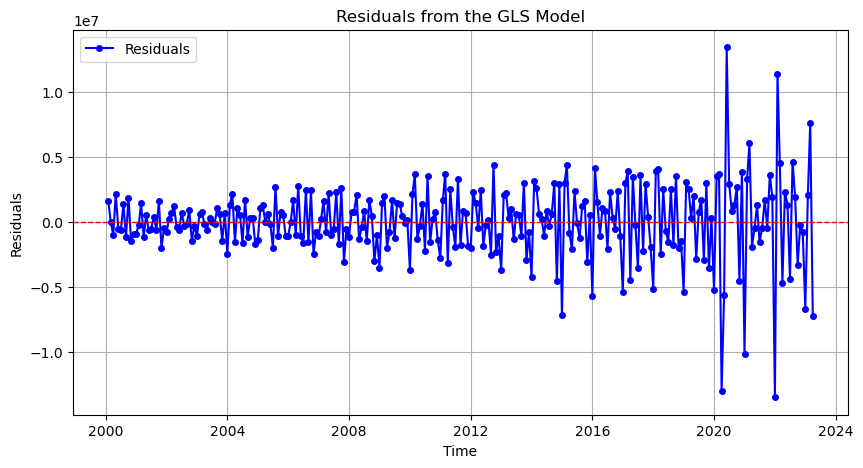

In [56]:
residuals_gls = gls_model.resid

plt.figure(figsize=(10, 5))
plt.plot(residuals_gls, label='Residuals', color='blue', linestyle='-', marker='o', markersize=4)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals from the GLS Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

- **Plot the ACF of the residuals**

We still can see autocorrelation in ACF, even with differenciated variables.

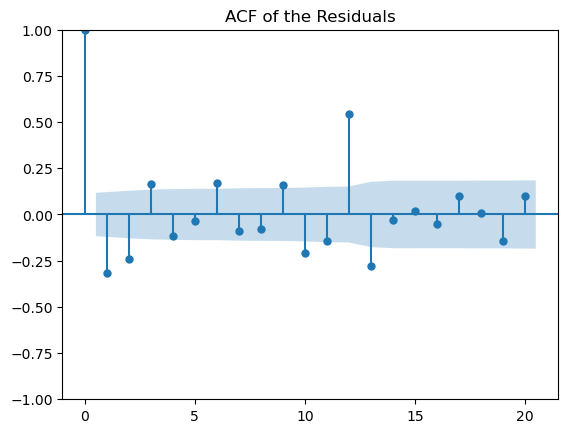

In [57]:
plot_acf(residuals_gls, lags=20)
plt.title('ACF of the Residuals')
plt.show()

We still can see autocorrelation in ACF, even with differenciated variables.**  

### **Stationarity**

- **Check stationarity of the variables**

In [58]:
adf_exp_td = adfuller(df2['exp_td'])
adf_exchange = adfuller(df2['exchange'])

For Exports: p-value > 0.05, so the series is non-stationary.

In [59]:
print('ADF test for Exports:', adf_exp_td)

ADF test for Exports: (0.7940829098123393, 0.9915400522312456, 15, 276, {'1%': -3.4542672521624214, '5%': -2.87206958769775, '10%': -2.5723807881747534}, 8837.05502670797)


For Exchange Rate: p-value > 0.05, so the series is non-stationary.

In [60]:
print('ADF test for Exchange Rate:', adf_exchange)

ADF test for Exchange Rate: (-1.3027707965203335, 0.6279037194045809, 2, 289, {'1%': -3.4531816058796143, '5%': -2.871593390724642, '10%': -2.5721268156511536}, 320.2178369714438)


For exp_td: p-value: 0.991540052 >0.05, we fail to reject the null hypothesis. This means that the exp_td series is non-stationary.

For exchange: P-value: 0.627903719 > 0.05,  exchange series is also non-stationary.

### **Test for cointegration**

We compare the trace statistic with the critical values (preferably 95%).  19.62>15.49(95%) ,  1.2252< 3.84(95%)

We accept Ha (alternative hypothesis) that there is at least one cointegration vector.

For example: det_order=0 (very common not deterministic trend no constant) and k_ar_diff=1 (one lagged difference)

- **Perform the Johansen cointegration test**

In [61]:
coint_test = coint_johansen(df2[['exp_td', 'exchange']], det_order=0, k_ar_diff=1)

In [62]:
print(coint_test.lr1)  # Trace statistic

[19.62901952  1.2252661 ]


In [63]:
print(coint_test.cvt)  # Critical values

[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


We compare the trace statistic with the critical values (preferably 95%)
- 19.62 > 19.93 (95%)
- 1.22  < 3.84 (95%)

We accept Ha (alternative hypothesis) that there is at least one cointegration vector and we can proceed with the VECM model.

### **Vector Error Correction Model**

**Triple solution:** Non normality in residuals, Non Stationary variables and Autocorrelation in time series.

- **Fit the VECM model**

In [64]:
vecm = VECM(df2[['exp_td', 'exchange']], k_ar_diff=1, coint_rank=1)
vecm_result = vecm.fit()

c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- **Print summary of the VECM**

The VECM model shows that there is a cointegration relationship between the two variables.

The loading coefficients (alpha) for the equations show the relationship between the variables.

The cointegration relations for the loading-coefficients-column 1 show the cointegration vector.

The model is suitable for forecasting the variables.

In [65]:
print(vecm_result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation exp_td
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.exp_td      -0.2977      0.053     -5.613      0.000      -0.402      -0.194
L1.exchange -2.148e+06   3.42e+05     -6.276      0.000   -2.82e+06   -1.48e+06
Det. terms outside the coint. relation & lagged endog. parameters for equation exchange
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.exp_td    8.862e-09   8.85e-09      1.002      0.317   -8.48e-09    2.62e-08
L1.exchange     0.2659      0.057      4.657      0.000       0.154       0.378
               Loading coefficients (alpha) for equation exp_td               
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

- **Plot the residuals to check for stationarity and white noise**

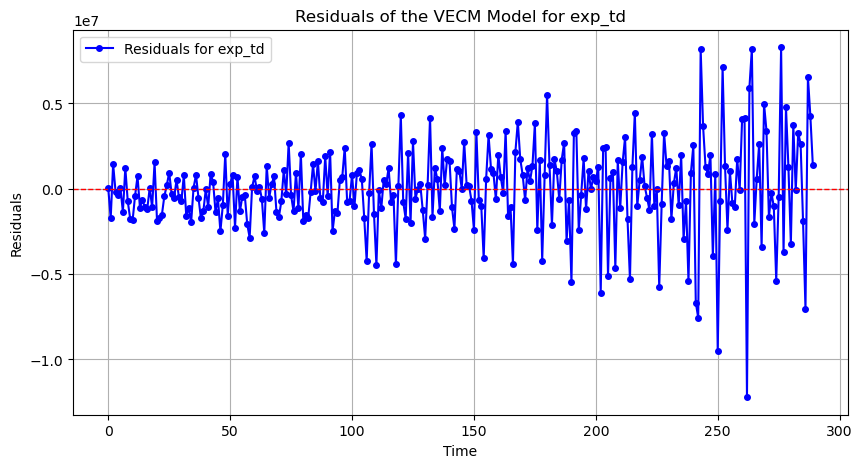

In [66]:
residuals_vecm = vecm_result.resid

plt.figure(figsize=(10, 5))
plt.plot(residuals_vecm[:, 0], label='Residuals for exp_td', color='blue', linestyle='-', marker='o', markersize=4)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals of the VECM Model for exp_td')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

- **Plot the residuals for the exchange rate**

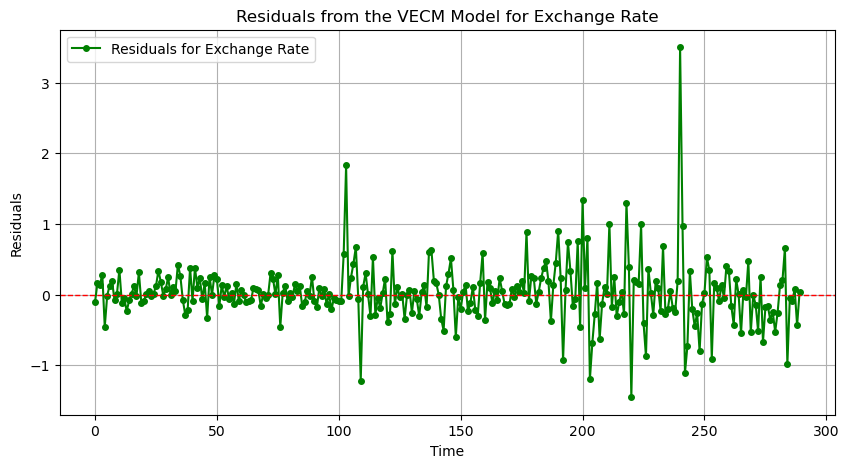

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(residuals_vecm[:, 1], label='Residuals for Exchange Rate', color='green', linestyle='-', marker='o', markersize=4)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals from the VECM Model for Exchange Rate')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

### **Forecast**

- **Number of steps to forecast**

In [68]:
steps = 12

- **Generate forecasts**

In [69]:
forecast = vecm_result.predict(steps=steps)

- **Convert forecast to DataFrame for better readability**

In [70]:
forecast_df = pd.DataFrame(forecast, columns=['exp_td_forecast', 'exchange_forecast'])

- **Add a datetime index to the forecast DataFrame**

In [79]:
last_date = pd.to_datetime('2024-04-01')  # End of historical data
forecast_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=steps, freq='ME')
forecast_df.index = forecast_dates

In [78]:
print(forecast_df)

            exp_td_forecast  exchange_forecast
2024-05-31     4.431725e+07          16.886859
2024-06-30     4.335987e+07          16.951409
2024-07-31     4.232600e+07          17.014138
2024-08-31     4.143161e+07          17.070539
2024-09-30     4.060726e+07          17.122008
2024-10-31     3.986285e+07          17.168654
2024-11-30     3.918649e+07          17.210996
2024-12-31     3.857314e+07          17.249405
2025-01-31     3.801661e+07          17.284253
2025-02-28     3.751174e+07          17.315868
2025-03-31     3.705369e+07          17.344550
2025-04-30     3.663813e+07          17.370571


- **Combine historical data with forecast**

In [73]:
historical_data = df2[['exp_td', 'exchange']]
combined_df = pd.concat([historical_data, forecast_df], axis=0)

- **Plot the historical data and forecasts**

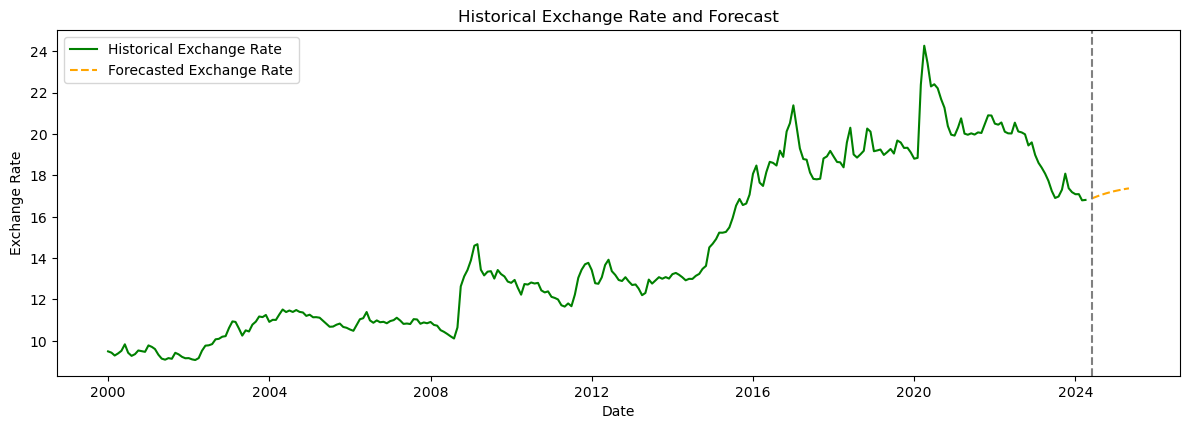

In [81]:
plt.figure(figsize=(12, 8))

# Plot historical and forecasted exports
# plt.subplot(2, 1, 1)
# plt.plot(combined_df.index[:len(historical_data)], combined_df['exp_td'][:len(historical_data)], label='Historical Exports', color='blue')
# plt.plot(combined_df.index[len(historical_data):], combined_df['exp_td_forecast'][len(historical_data):], label='Forecasted Exports', color='red', linestyle='--')
# plt.axvline(x=forecast_dates[0], color='gray', linestyle='--')
# plt.title('Historical Exports and Forecast')
# plt.xlabel('Date')
# plt.ylabel('Exports')
# plt.legend()
# plt.show()

# Plot historical and forecasted exchange rate
plt.subplot(2, 1, 2)
plt.plot(combined_df.index[:len(historical_data)], combined_df['exchange'][:len(historical_data)], label='Historical Exchange Rate', color='green')
plt.plot(combined_df.index[len(historical_data):], combined_df['exchange_forecast'][len(historical_data):], label='Forecasted Exchange Rate', color='orange', linestyle='--')
plt.axvline(x=forecast_dates[0], color='gray', linestyle='--')
plt.title('Historical Exchange Rate and Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()

plt.tight_layout()
plt.show()